# Demonstration of the conversion pipeline using time-resolved ARPES data stored on Zenodo
In this example, we pull some time-resolved ARPES data from Zenodo, and load it into the sed package using functions of the mpes package. Then, we run a conversion pipeline on it, containing steps for visualizing the channels, correcting image distortions, calibrating the momentum space, correcting for energy distortions and calibrating the energy axis. Finally, the data are binned in calibrated axes.
For performance reasons, best store the data on a locally attached storage (no network drive). This can also be achieved transparently using the included MirrorUtil class.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os

import sed

%matplotlib widget

## Load Data

In [2]:
data_path = '.' # Put in Path to a storage of at least 20 Gbyte free space.
if not os.path.exists(data_path + "/WSe2.zip"):
    os.system(f"curl -L --output {data_path}/WSe2.zip https://zenodo.org/record/6369728/files/WSe2.zip")
if not os.path.isdir(data_path + "/Scan049_1") or not os.path.isdir(data_path + "/energycal_2019_01_08/"):
    os.system(f"unzip -d {data_path} -o {data_path}/WSe2.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   249  100   249    0     0   1915      0 --:--:-- --:--:-- --:--:--  1915
100 5869M  100 5869M    0     0   104M      0  0:00:56  0:00:56 --:--:--  104M


In [3]:
# The Scan directory
fdir = data_path + '/Scan049_1'
# create sed processor using the config file:
sp = sed.SedProcessor(folder=fdir, config="../sed/config/mpes_example_config.yaml")

Configuration loaded from: [/mnt/pcshare/users/Laurenz/AreaB/sed/sed/sed/config/mpes_example_config.yaml]
Folder config loaded from: [/mnt/pcshare/users/Laurenz/AreaB/sed/sed/tutorial/sed_config.yaml]
System config loaded from: [/mnt/pcshare/sed/config.yaml]
Default config loaded from: [/mnt/pcshare/users/Laurenz/AreaB/sed/sed/sed/config/default.yaml]


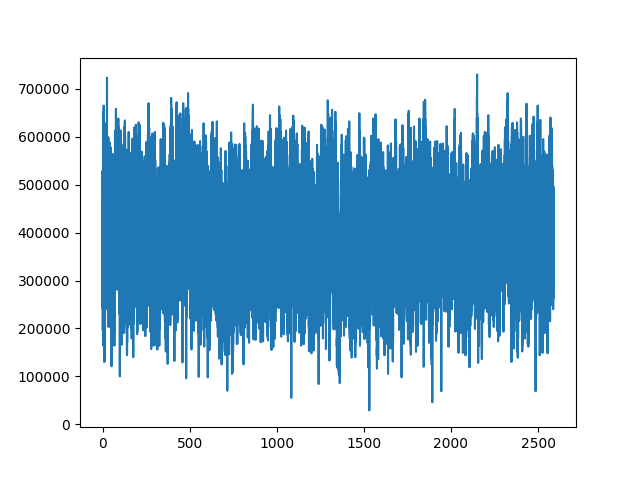

In [4]:
# Plot of the count rate through the scan
rate, secs = sp.loader.get_count_rate(range(100))
plt.plot(secs, rate)

In [5]:
# The time elapsed in the scan
sp.loader.get_elapsed_time()

2588.4949999999994

In [6]:
# Apply jittering to X, Y, t, ADC columns.
# Columns are defined in the config, or can be provided as list.
sp.add_jitter()

In [7]:
# Inspect data in dataframe Columns:
# axes = ['X', 'Y', 't', 'ADC']
# bins = [100, 100, 100, 100]
# ranges = [(0, 1800), (0, 1800), (130000, 140000), (0, 9000)]
# sp.viewEventHistogram(dfpid=1, axes=axes, bins=bins, ranges=ranges)
sp.view_event_histogram(dfpid=2)

## Distortion correction and Momentum Calibration workflow
### Distortion correction
#### 1. step: 
Bin and load part of the dataframe in detector coordinates, and choose energy plane where high-symmetry points can well be identified. Either use the interactive tool, or pre-select the range:

  0%|          | 0/5 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=33, description='plane', max=290), IntSlider(value=10, description='widt…

Button(description='apply', style=ButtonStyle())

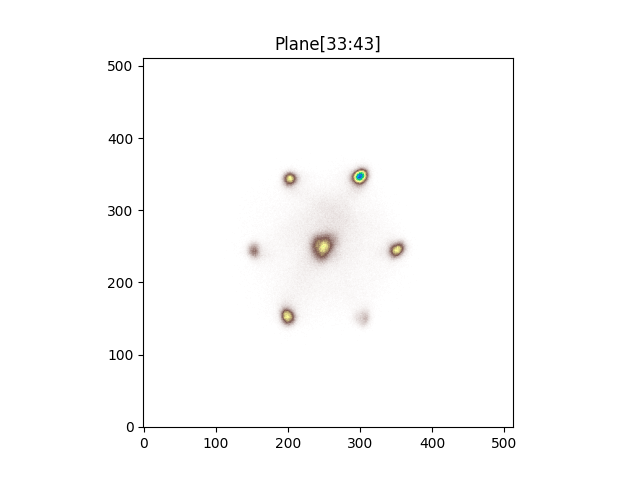

In [8]:
#sp.bin_and_load_momentum_calibration(df_partitions=20, plane=170)
sp.bin_and_load_momentum_calibration(df_partitions=100, plane=33, width=10, apply=True)

#### 2. Step:
Next, we select a number of features corresponding to the rotational symmetry of the material, plus the center. These can either be auto-detected (for well-isolated points), or provided as a list (these can be read-off the graph in the cell above).
These are then symmetrized according to the rotational symmetry, and a spline-warping correction for the x/y coordinates is calculated, which corrects for any geometric distortions from the perfect n-fold rotational symmetry.

interactive(children=(Dropdown(description='Point:', options=(0, 1, 2, 3, 4, 5, 6), value=0), Output()), _dom_…

interactive(children=(FloatText(value=153.40923361300395, description='point_x'), FloatText(value=243.06399842…

Button(description='apply', style=ButtonStyle())

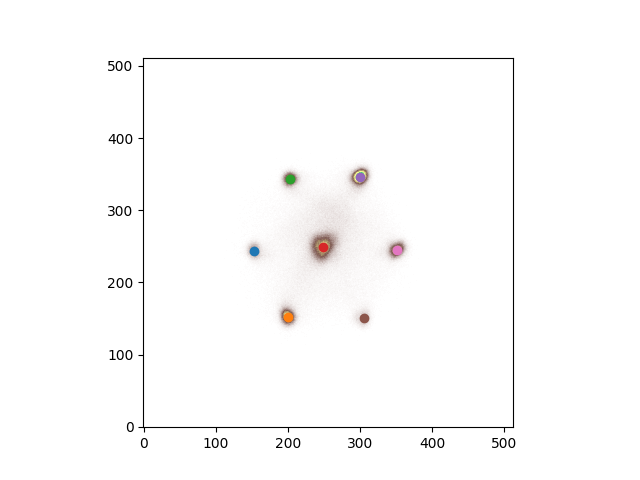

In [9]:
#features = np.array([[203.2, 341.96], [299.16, 345.32], [350.25, 243.70], [304.38, 149.88], [199.52, 152.48], [154.28, 242.27], [248.29, 248.62]])
#sp.define_features(features=features, rotation_symmetry=6, include_center=True, apply=True)
# Manual selection: Use a GUI tool to select peaks:
#sp.define_features(rotation_symmetry=6, include_center=True)
#sp.generate_splinewarp(rotation_symmetry=6, include_center=True, fwhm=10, sigma=12, sigma_radius=4)
# Autodetect: Uses the DAOStarFinder routine to locate maxima.
# Parameters are:
#   fwhm: Full-width at half maximum of peaks.
#   sigma: Number of standard deviations above the mean value of the image peaks must have.
#   sigma_radius: number of standard deviations around a peak that peaks are fitted
sp.define_features(rotation_symmetry=6, auto_detect=True, include_center=True, fwhm=10, sigma=12, sigma_radius=4, apply=True)

#### 3. Step: 
Generate nonlinear correction using splinewarp algorithm. If no landmarks have been defined in previous step, default parameters from the config are used

In [10]:
# Option whether a central point shall be fixed in the determiantion fo the correction
sp.generate_splinewarp(include_center=True)

Calulated thin spline correction based on the following landmarks:
pouter: [[153.40923361 243.06399842]
 [199.53985    152.77801048]
 [202.99667165 342.98417372]
 [299.87095669 346.19512647]
 [305.62681108 150.20132112]
 [350.95080745 244.79082303]]
pcent: (249.232157094759, 249.2577242394875)
Original slice with reference features


Corrected slice with target features


Original slice with target features


#### Optional (Step 3a): 
Save distortion correction parameters to configuration file in current data folder: 

In [11]:
# Save generated distortion correction parameters for later reuse
sp.save_splinewarp()

#### 4. Step:
To adjust scaling, position and orientation of the corrected momentum space image, you can apply further affine transformations to the distortion correction field. Here, first a postential scaling is applied, next a translation, and finally a rotation around the center of the image (defined via the config). One can either use an interactive tool, or provide the adjusted values and apply them directly.

interactive(children=(FloatSlider(value=1.0, description='scale', max=1.2, min=0.8, step=0.01), FloatSlider(va…

Button(description='apply', style=ButtonStyle())

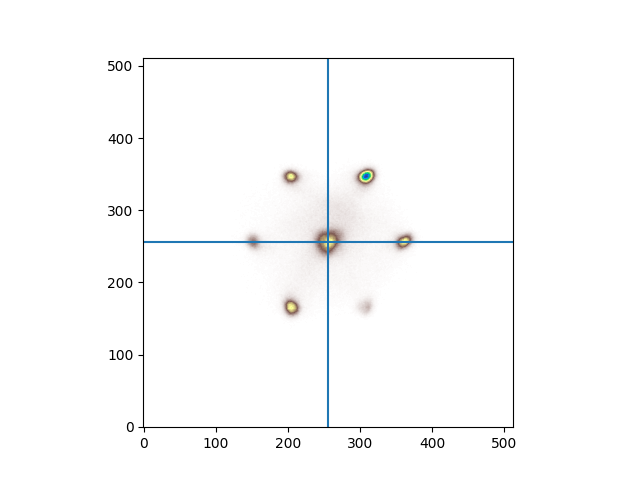

Output()

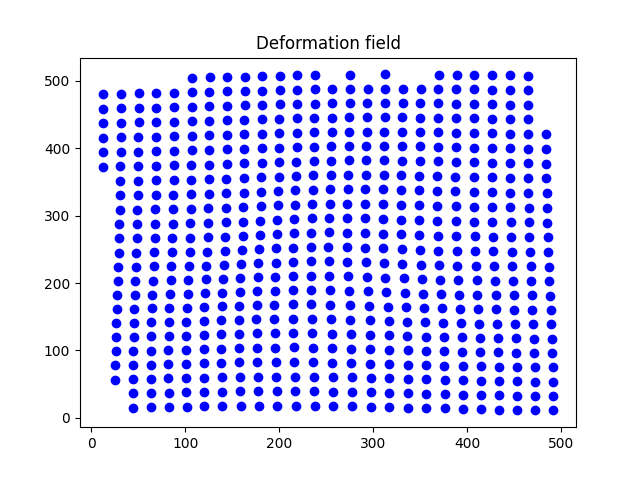

In [12]:
#sp.pose_adjustment(xtrans=14, ytrans=18, angle=2)
sp.pose_adjustment(xtrans=8, ytrans=7, angle=-4, apply=True)

#### 5. Step:
Finally, the momentum correction is applied to the dataframe, and corresponding meta data are stored

In [13]:
sp.apply_momentum_correction()

Adding corrected X/Y columns to dataframe:
Calculating inverse deformation field, this might take a moment...
Dask DataFrame Structure:
                       X        Y        t      ADC       Xm       Ym
npartitions=100                                                      
                 float64  float64  float64  float64  float64  float64
                     ...      ...      ...      ...      ...      ...
...                  ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...
Dask Name: apply_dfield, 206 graph layers


### Momentum calibration workflow
#### 1. Step:
First, the momentum scaling needs to be calibtrated. Either, one can provide the coordinates of one point outside the center, and provide its distane to the Brillouin zone center (which is assumed to be located in the center of the image), one can specify two points on the image and their distance (where the 2nd point marks the BZ center),or one can provide absolute k-coordinates of two distinct momentum points.

If no points are provided, an interactive tool is created. Here, left mouse click selectes the off-center point (brillouin_zone_cetnered=True) or toggle-selects the off-center and center point.

interactive(children=(IntText(value=308, description='point_a_x'), IntText(value=345, description='point_a_y')…

Button(description='apply', style=ButtonStyle())

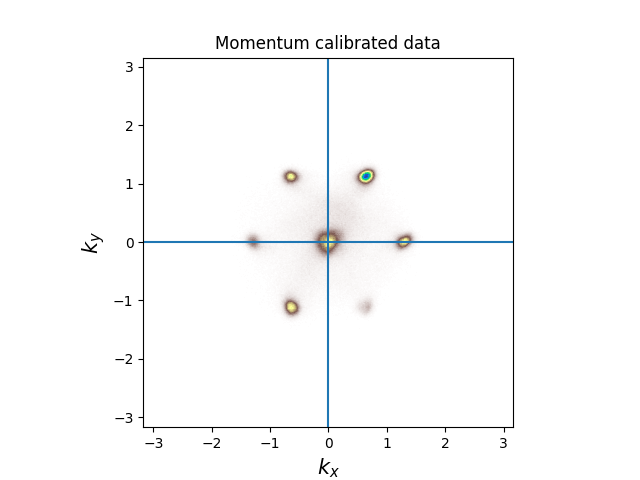

In [14]:
k_distance = 4/3*np.pi/3.28
#sp.calibrate_momentum_axes(k_distance = k_distance)
point_a = [308, 345]
sp.calibrate_momentum_axes(point_a=point_a, k_distance = k_distance, apply=True)
#point_b = [247, 249]
#sp.calibrate_momentum_axes(point_a=point_a, point_b = point_b, k_coord_a = [.5, 1.1], k_coord_b = [1.3, 0], equiscale=False

##### Optional (Step 1a): 
Save momentum calibration parameters to configuration file in current data folder: 

In [15]:
# Save generated momentum calibration parameters for later reuse
sp.save_momentum_calibration()

#### 2. Step:
Now, the distortion correction and momentum calibration needs to be applied to the dataframe.

In [16]:
sp.apply_momentum_calibration()

Adding kx/ky columns to dataframe:
Dask DataFrame Structure:
                       X        Y        t      ADC       Xm       Ym       kx       ky
npartitions=100                                                                        
                 float64  float64  float64  float64  float64  float64  float64  float64
                     ...      ...      ...      ...      ...      ...      ...      ...
...                  ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...
Dask Name: assign, 216 graph layers


## Energy Correction (optional)
The purpose of the energy correction is to correct for any momentum-dependent distortion of the energy axis, e.g. from geometric effects in the flight tube, or from space charge

#### 1st step:
Here, one can select the functional form to be used, and adjust its parameters. The binned data used for the momentum calibration is plotted around the Fermi energy (defined by tof_fermi), and the correction function is plotted ontop. Possible correction functions are: "sperical" (parameter: diameter), "Lorentzian" (parameter: gamma), "Gaussian" (parameter: sigma), and "Lorentzian_asymmetric" (parameters: gamma, amplitude2, gamma2).

One can either use an interactive alignment tool, or provide parameters directly.

interactive(children=(FloatSlider(value=2.5, description='amplitude', max=10.0), FloatSlider(value=730.0, desc…

Button(description='apply', style=ButtonStyle())

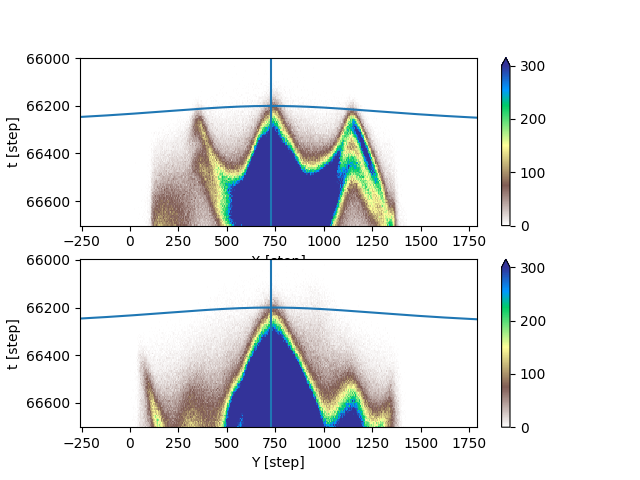

In [17]:
#sp.adjust_energy_correction(amplitude=2.5, center=(730, 730), gamma=920, tof_fermi = 66200)
sp.adjust_energy_correction(amplitude=2.5, center=(730, 730), gamma=920, tof_fermi = 66200, apply=True)

##### Optional (Step 1a): 
Save energy correction parameters to configuration file in current data folder: 

In [18]:
# Save generated energy correction parameters for later reuse
sp.save_energy_correction()

#### 2. Step
After adjustment, the energy correction is directly applied to the TOF axis.

In [19]:
sp.apply_energy_correction()

Applying energy correction to dataframe...
Dask DataFrame Structure:
                       X        Y        t      ADC       Xm       Ym       kx       ky       tm
npartitions=100                                                                                 
                 float64  float64  float64  float64  float64  float64  float64  float64  float64
                     ...      ...      ...      ...      ...      ...      ...      ...      ...
...                  ...      ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...      ...
Dask Name: assign, 230 graph layers


## 3. Energy calibration
For calibrating the energy axis, a set of data taken at different bias voltages around the value where the measurement was taken is required.

#### 1. Step:
In a first step, the data are loaded, binned along the TOF dimension, and normalized. The used bias voltages can be either provided, or read from attributes in the source files if present.

In [20]:
# Load energy calibration EDCs
energycalfolder = data_path + "/energycal_2019_01_08/"
scans = np.arange(1,12)
voltages = np.arange(12,23,1)
files = [energycalfolder + r'Scan' + str(num).zfill(3) + '_' + str(num+11) + '.h5' for num in scans]
sp.load_bias_series(data_files=files, normalize=True, biases=voltages, ranges=[(64000, 75000)])

  0%|          | 0/1 [00:00<?, ?it/s]

#### 2. Step:
Next, the same peak or feature needs to be selected in each curve. For this, one needs to define "ranges" for each curve, within which the peak of interest is located. One can either provide these ranges manually, or provide one range for a "reference" curve, and infer the ranges for the other curves using a dynamic time warping algorithm.

interactive(children=(IntSlider(value=5, description='refid', max=10), IntRangeSlider(value=(66100, 67000), de…

Button(description='apply', style=ButtonStyle())

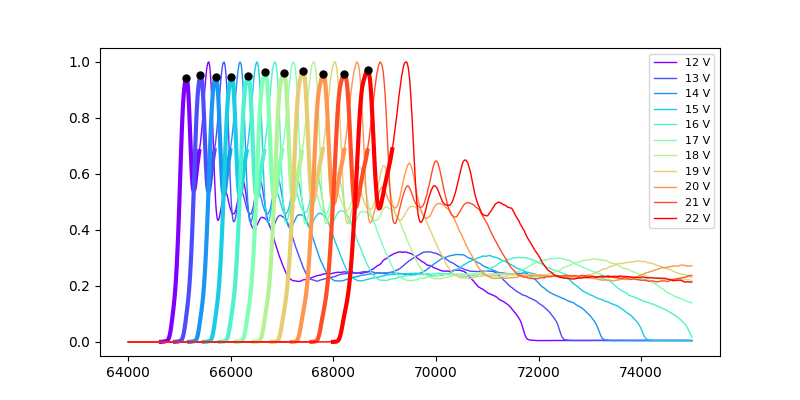

In [21]:
# Option 1 = specify the ranges containing a common feature (e.g an equivalent peak) for all bias scans
# rg = [(129031.03103103103, 129621.62162162163), (129541.54154154155, 130142.14214214214), (130062.06206206206, 130662.66266266267), (130612.61261261262, 131213.21321321322), (131203.20320320321, 131803.8038038038), (131793.7937937938, 132384.38438438438), (132434.43443443443, 133045.04504504506), (133105.10510510512, 133715.71571571572), (133805.8058058058, 134436.43643643643), (134546.54654654654, 135197.1971971972)]
# sp.find_bias_peaks(ranges=rg, infer_others=False)
# Option 2 = specify the range for one curve and infer the others
# This will open an interactive tool to select the correct ranges for the curves.
# IMPORTANT: Don't choose the range too narrow about a peak, and choose a refid
# somewhere in the middle or towards larger biases!
rg = (66100, 67000)
sp.find_bias_peaks(ranges=rg, ref_id=5, infer_others=True, apply=True)

#### 3. Step:
Next, the detected peak positions and bias voltages are used to determine the calibration function. This can be either done by fitting the functional form d^2/(t-t0)^2 via lmfit ("lmfit"), or using a polynomial approxiamtion ("lstsq" or "lsqr"). Here, one can also define a reference id, and a reference energy. Those define the absolute energy position of the feature used for calibration in the "reference" trace, at the bias voltage where the final measurement has been performed. The energy scale can be either "kientic" (decreasing energy with increasing TOF), or "binding" (increasing energy with increasing TOF).

After calculating the calibration, all traces corrected with the calibration are plotted ontop of each other, the calibration function together with the extracted features is plotted.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 11
    # variables        = 3
    chi-square         = 0.00212334
    reduced chi-square = 2.6542e-04
    Akaike info crit   = -88.0792774
    Bayesian info crit = -86.8855916
[[Variables]]
    d:   1.09544523 +/- 0.03592316 (3.28%) (init = 1)
    t0:  7.6073e-07 +/- 7.4488e-09 (0.98%) (init = 1e-06)
    E0: -46.6134132 +/- 0.64225187 (1.38%) (init = -22)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, t0)  = -1.000
    C(d, E0)  = -0.999
    C(t0, E0) = 0.997
Quality of Calibration:


E/TOF relationship:


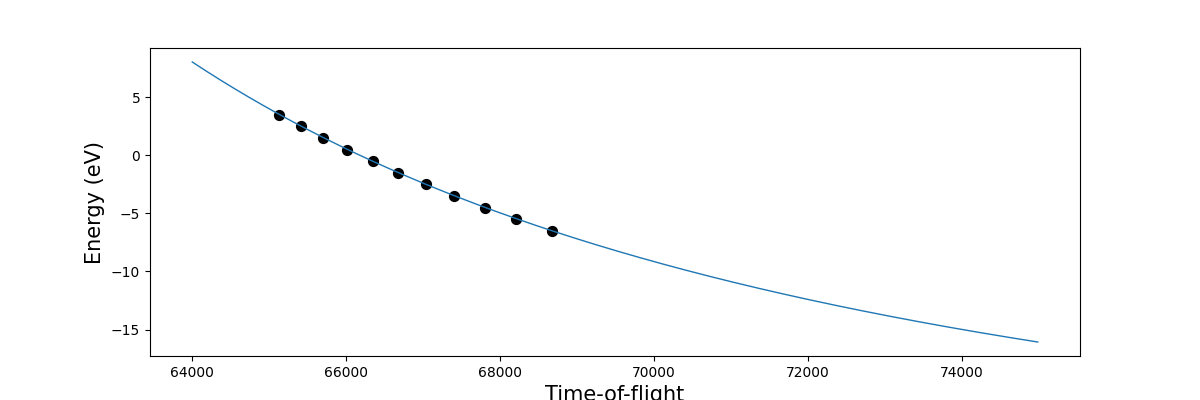

In [22]:
# use the refid of the bias that the measurement was taken at
# Eref can be used to set the absolute energy (kinetic energy, E-EF) of the feature used for energy calibration (if known)
refid=4
Eref=-0.5
# the lmfit method uses a fit of (d/(t-t0))**2 to determine the energy calibration
sp.calibrate_energy_axis(ref_energy=Eref, ref_id=refid, energy_scale="kinetic", method="lmfit")

##### Optional (Step 3a): 
Save energy calibration parameters to configuration file in current data folder: 

In [23]:
# Save generated energy calibration parameters for later reuse
sp.save_energy_calibration()

#### 4. Step:
Finally, the the energy axis is added to the dataframe.

In [24]:
sp.append_energy_axis()

Adding energy column to dataframe:
Dask DataFrame Structure:
                       X        Y        t      ADC       Xm       Ym       kx       ky       tm   energy
npartitions=100                                                                                          
                 float64  float64  float64  float64  float64  float64  float64  float64  float64  float64
                     ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
...                  ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
                     ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
Dask Name: assign, 240 graph layers


## 4. Delay calibration:
The delay axis is calculated from the ADC input column based on the provided delay range. ALternatively, the delay scan range can also be extracted from attributes inside a source file, if present.

In [25]:
#from pathlib import Path
#datafile = "file.h5"
#print(datafile)
#sp.calibrate_delay_axis(datafile=datafile)
delay_range = (-500, 1500)
sp.calibrate_delay_axis(delay_range=delay_range, preview=True)

Adding delay column to dataframe:
             X            Y             t          ADC           Xm  \
0     0.170168     0.170168      0.170168     0.170168   -12.835257   
1   365.456374  1002.456374  70101.456374  6317.456374   355.359878   
2   760.610345   817.610345  75614.610345  6315.610345   789.475702   
3   691.768016   970.768016  66454.768016  6316.768016   711.944452   
4   670.699920   711.699920  73025.699920  6316.699920   695.320993   
5   298.643382  1163.643382  68458.643382  6315.643382   281.342979   
6   571.267949   665.267949  73903.267949  6316.267949   589.158394   
7   821.811486   544.811486  72631.811486  6317.811486   846.288178   
8   817.910077   415.910077  72421.910077  6316.910077   836.854612   
9  1006.495154   667.495154  72802.495154  6317.495154  1038.591499   

            Ym        kx        ky            tm     energy        delay  
0    87.159818 -2.417046 -2.106720    -48.030723 -25.209521  -660.280112  
1  1030.474465 -1.274385  0.820773

## 5. Visualization of calibrated histograms
With all calibrated axes present in the dataframe, we can visualize the corresponding histograms, and determine the respective binning ranges

In [26]:
axes = ['kx', 'ky', 'energy', 'delay']
ranges = [[-3, 3], [-3, 3], [-6, 2], [-600, 1600]]
sp.view_event_histogram(dfpid=1, axes=axes, ranges=ranges)

## Define the binning ranges and compute calibrated data volume

In [27]:
axes = ['kx', 'ky', 'energy', 'delay']
bins = [100, 100, 200, 50]
ranges = [[-2, 2], [-2, 2], [-4, 2], [-600, 1600]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/5 [00:00<?, ?it/s]

## Some visualization:

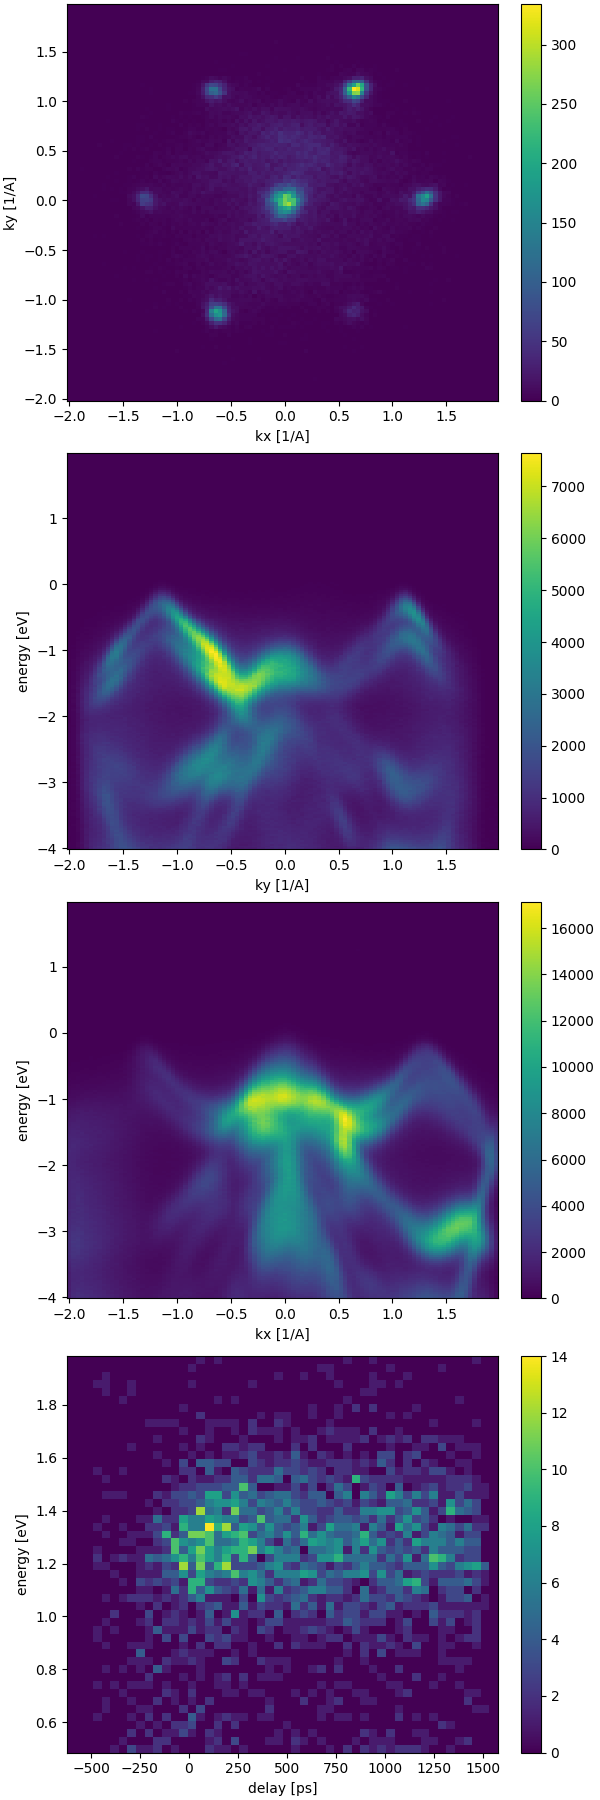

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(6, 18), constrained_layout=True)
res.loc[{'energy':slice(-.1, 0)}].sum(axis=(2,3)).T.plot(ax=axs[0])
res.loc[{'kx':slice(-.8, -.5)}].sum(axis=(0,3)).T.plot(ax=axs[1])
res.loc[{'ky':slice(-.2, .2)}].sum(axis=(1,3)).T.plot(ax=axs[2])
res.loc[{'kx':slice(-.8, -.5), 'energy':slice(.5, 2)}].sum(axis=(0,1)).plot(ax=axs[3])